# 트랜스포머로 만드는 대화형 챗봇 프로젝트 🌠

#### 전처리 전략
- 전처리 함수 ```normalize_ko``` 정의
- 특수 문자 제거 / 영어 대문자 소문자 변환 / 반복 구두점, ㅋㅋ, ㅎㅎ 줄이기
- SentencePiece 학습을 위해 정제된 Q/A 쌍을 따로 저장하고 나서 토크나이저 학습

#### 데이터셋 구성
- ChatDataset에서 Q/A 쌍을 불러와 ```torch.tensor```로 변환
- 길이 정보까지 반환하여 Collate 함수에서 총 4개의 값이 반환

#### 모델 구조
- Attention / Positional Encoding / MultiHead Attention 직접 구현

#### 학습 및 평가
- 학습 루프에서 CorssEntropyLoss, Gradient Clipping 적용
- 학습 이후 Validation Loss 계산

#### 추론
- greedy_decode(msg) 함수 이용 (입력 문장 토크나이징 - 트렌스포머 - 토큰 생성 반복 - 디코딩)

### 1. 라이브러리 불러오기

- ```SentencePiece``` : 텍스트 토큰화 라이브러리로, 특히 한국어와 일본어 같이 띄어쓰기 구분이 애매한 언어에서 자주 사용됩니다.

In [1]:
!pip install -q torch sentencepiece pandas tqdm scikit-learn

In [2]:
# 패키지 임포트

import os, re, unicodedata, random
import pandas as pd
import sentencepiece as spm

import math, time, random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

### 2. 데이터 전처리

In [3]:
pwd

'/home/jovyan/work/0818'

In [4]:
# 데이터셋 경로 지정
CSV_PATH = "./transformer_chatbot/data/ChatbotData.csv"

# 데이터셋 불러오기
df = pd.read_csv(CSV_PATH)

# 데이터 프레임에 Q/A가 들어와 확인해주는 용도
assert "Q" in df.columns and "A" in df.columns

df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- ```ALLOWED``` : 허용된 문자(영어, 숫자, 한글, 기본 특수문자)만 남기고 나머지는 제거합니다.
- ```_re_mult_punct``` : !!, ??, ~~~ 같이 같은 문장부호가 여러 번 반복될 때 하나만 남깁니다.
- ```_re_kor_repeat``` : 같은 한글 문자가 3번 이상 반복되면 줄입니다. (예: "ㅋㅋㅋㅋ" → "ㅋㅋ")
- ```_re_lol``` : 웃음 표현(ㅋㅋㅋ, ㅎㅎㅎ)도 줄입니다.
- ```_re_ws``` : 공백 여러 개를 하나로 줄입니다.

In [5]:
# 전처리 함수 정의

ALLOWED = r"[^0-9a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ\s\.\,\?\!\~…\:\;\/\-\’\'\"\(\)\[\]]"
_re_mult_punct = re.compile(r"([\.?!~…])\1{1,}")
_re_kor_repeat  = re.compile(r"([가-힣ㄱ-ㅎㅏ-ㅣ])\1{2,}")
_re_lol         = re.compile(r"(ㅋ|ㅎ)\1{2,}")
_re_ws          = re.compile(r"\s+")

In [6]:
# 한국어 문장을 정제하는 함수

def normalize_ko(s):
    s = unicodedata.normalize("NFKC", s) # 유니코드 표준화 (같은 글자지만 다른 코드값을 통일)
    s = re.sub(r"[A-Z]", lambda m: m.group(0).lower(), s) # 영어 대문자를 소문자로 변환하기
    s = re.sub(ALLOWED, " ", s) # 허용되지 않은 문자는 제거합니다.
    s = _re_mult_punct.sub(r"\1", s) # 반복 문장 부호도 제거합니다.
    s = _re_lol.sub(lambda m: m.group(1)*2, s) # 웃음 표현도 줄입니다.
    s = _re_kor_repeat.sub(lambda m: m.group(1)*2, s) # 한글 글자가 3번 이상 반복되면 줄입니다.
    s = _re_ws.sub(" ", s).strip() # 공백이 여러 개일 때도 하나로 줄이고 양쪽 공백을 제거합니다.
    return s

In [7]:
# Q/A를 normalize_ko를 이용해서 정제합니다.
df["Q_norm"] = df["Q"].astype(str).map(normalize_ko)
df["A_norm"] = df["A"].astype(str).map(normalize_ko)

# 너무 짧거나 긴 문장 제거 (1~80 단어 범위 밖)
df = df[(df["Q_norm"].str.split().str.len().between(1, 80)) &
        (df["A_norm"].str.split().str.len().between(1, 80))]

# 중복된 Q/A는 제거합니다.
df = df.drop_duplicates(subset=["Q_norm", "A_norm"]).reset_index(drop=True)

# 결과 미리보기
df[["Q_norm", "A_norm"]].sample(5, random_state=42)

,Q_norm,A_norm
6578,사랑이란 뭘까?,사랑에는 답이 없어요.
4597,친구가 나 귀엽대,친구가 보는 눈이 있네요.
5748,끝이네,수고했어요.
5627,그녀는 무슨 생각일까?,그녀밖에 알 수가 없죠.
8390,한번의 기회쯤 있겠지 라고 생각했던 내생각이 어리석었습니다,현실을 받아들이는 것도 중요합니다.


### 3. SentencePiece 사용하기

- 토크나이저 학습 단계로, Q/A를 모두 모아 ```spm_corpus.txt```에 저장합니다.
- 정제된 병렬 데이터도 ```parallel_ko_clean.csv```로 저장합니다.

- ```vocab_size=4000``` : 어휘 개수 4000개
- ```model_type=unigram``` : 유니그램 언어모델 기반 토크나이저
- ```character_coverage=0.9995``` : 거의 모든 한글/영문 글자 커버
- 특수 토큰 ID 지정 (PAD=0, UNK=1, BOS=2, EOS=3)

In [8]:
# SentencePiece 학습용 말뭉치 저장 (질문+답변) -> 모든 문장이 한 줄씩 들어간 큰 코퍼스 생성
with open("spm_corpus.txt", "w", encoding="utf-8") as f:
    for s in df["Q_norm"].tolist() + df["A_norm"].tolist():
        f.write(s + "\n")

# 병렬 CSV도 저장 (질문과 답변이 나란히 있는 병렬 데이터셋)
# 나중에 모델 학습 단계에서 입력과 정답 출력이 필요합니다.
df[["Q_norm", "A_norm"]].to_csv("parallel_ko_clean.csv", index=False, encoding="utf-8")

# SentencePiece 학습
spm.SentencePieceTrainer.Train(
    "--input=spm_corpus.txt --model_prefix=spm_ko --vocab_size=4000 "
    "--character_coverage=0.9995 --model_type=unigram "
    "--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3"
)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=spm_corpus.txt --model_prefix=spm_ko --vocab_size=4000 --character_coverage=0.9995 --model_type=unigram --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: spm_corpus.txt
  input_format: 
  model_prefix: spm_ko
  model_type: UNIGRAM
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vo

- ```--input=spm_corpus.txt``` : 방금 만든 말뭉치 파일을 입력으로 사용
- ```--model_prefix=spm_ko``` : 결과물 파일 이름 앞에 붙을 접두사 (spm_ko.model, spm_ko.vocab 생성됨)
- ```--vocab_size=4000``` : 어휘 사전 크기 (4000개의 토큰 학습)
- ```--character_coverage=0.9995``` : 전체 문자 중 99.95%를 커버하도록 (희귀 문자 제외)
- ```--model_type=unigram``` : 토큰화를 유니그램 언어모델 기반으로 학습 (BPE, WordPiece도 선택 가능)
- ```--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3``` : 특수 토큰 ID를 직접 지정

In [9]:
# 학습된 tokenizer 로드
sp = spm.SentencePieceProcessor()
sp.load("spm_ko.model")

# 어휘 크기 확인
VOCAB_SIZE = sp.get_piece_size()
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 4000


In [10]:
# 어휘 크기 확인 (토크나이저 사전 크기)
VOCAB_SIZE = sp.get_piece_size()

# 특수 토큰 ID 설정하기
PAD, UNK, BOS, EOS = 0, 1, 2, 3

MAX_LEN = 64

- ```PAD = 0``` : 문장 길이를 맞추려고 빈 부분에 넣는 토큰

- ```UNK = 1``` : 사전에 없는 단어가 들어왔을 때 대체하는 토큰

- ```BOS = 2``` : 문장의 시작을 알리는 토큰 (Begin of Sentence)

- ```EOS = 3``` : 문장의 끝을 알리는 토큰 (End of Sentence)

### 4. Transformer 모델 구성하기

In [11]:
class ChatDataset(Dataset):

    # 정제된 병렬 데이터를 Q/A 쌍을오 묶어 리스트에 저장 [(Q, A)] 형태
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.pairs = list(zip(df["Q_norm"].tolist(), df["A_norm"].tolist()))

    # 전체 데이터 샘플 개수 반환
    def __len__(self):
        return len(self.pairs)

    # 특정 인덱스의 Q/A 쌍 가져오기
    def __getitem__(self, idx):
        q, a = self.pairs[idx]
        q_ids = sp.encode(q, out_type=int)[:MAX_LEN-1] + [EOS]
        a_ids = sp.encode(a, out_type=int)[:MAX_LEN-1] + [EOS]
        return torch.tensor(q_ids), torch.tensor(a_ids)

# 데이터 로더가 여러 샘플을 모아올 때 실행하는 함수
def collate_fn(batch):
    qs, ans = zip(*batch) # 질문과 답변 시퀀스를 각각 모아서 리스트로 분리
    q_lens = [len(x) for x in qs]
    a_lens = [len(x) for x in ans]

    # 각 시퀀스를 가장 긴 문장 길이에 맞춰 패딩 처리
    q_pad = nn.utils.rnn.pad_sequence(qs, padding_value=PAD, batch_first=True)
    a_pad = nn.utils.rnn.pad_sequence(ans, padding_value=PAD, batch_first=True)
    return q_pad, a_pad, torch.tensor(q_lens), torch.tensor(a_lens)

In [12]:
# Transformer - Positional Encoding

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model) # 위치 인코딩 값을 담을 2D 텐서
        pos = torch.arange(0, max_len).unsqueeze(1) # 위치 인덱스

        # 주기 계산 - 위치마다 고유한 주기 패턴을 가질 수 있음 sin, cos 값
        # 10000^(2i/d_model) 꼴의 분모를 만든 것
        div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0)/d_model))

        # sin, cos 값 채우기
        pe[:, 0::2] = torch.sin(pos*div)
        pe[:, 1::2] = torch.cos(pos*div)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    # 임베딩 벡터와 위치 정보가 결합됩니다.
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [13]:
# Scaled Dot-Product Attention

def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.size(-1) # 쿼리의 마지막 차원 크기로 스케일링 하기 위해 저장

    # 유사도 계산
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    # Decoder의 경우 Look-ahead 마스킹 적용
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)

    # Attention 확률 분포 - SoftMax
    attn = torch.softmax(scores, dim=-1)

    # Attention * value = 가중합
    return torch.matmul(attn, v), attn

In [14]:
# MultiHead Attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

    # 각 Attention Head가 자기의 차원에서 독립적으로 계산 가능
    def forward(self, q, k, v, mask=None):
        B = q.size(0)
        q = self.q_linear(q).view(B, -1, self.num_heads, self.d_k).transpose(1,2)
        k = self.k_linear(k).view(B, -1, self.num_heads, self.d_k).transpose(1,2)
        v = self.v_linear(v).view(B, -1, self.num_heads, self.d_k).transpose(1,2)

        # 여기서 본격적으로 Scaled Dot-Product Attention을 수행합니다.
        scores, attn = scaled_dot_product_attention(q,k,v,mask)

        # Head의 결과들을 concat으로 합친 다음에 원래 차원으로 복원합니다.
        concat = scores.transpose(1,2).contiguous().view(B,-1,self.num_heads*self.d_k)
        return self.fc(concat)

# FFN - 각 토큰 위치마다 독립적으로 FFN을 적용합니다.
class PositionwiseFF(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    # 비선형 변환을 통해 모델의 표현력을 키우기
    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

[흐름]

**1. Self-Attention**
- 입력 ```x```를 Query/Key/Value로 넣어 자기 자신과의 관계를 학습
- 결과 ```attn_out```

**2. Residual Connection + Norm**
- ```x + attn_out``` : 잔차 연결(residual)
- LayerNorm으로 정규화

**3. Feed Forward**
- 위치별 FFN 적용

**4. Residual Connection + Norm**
- ```x + ff_out``` : 다시 LayerNorm

※ 즉, “Self-Attention → FFN” 구조가 하나의 Encoder Layer입니다.

- ReLU를 사용해서 입력 공간을 꺾어 선형 변환만으로 표현이 어려운 복잡한 함수 및 패턴을 모델링할 수 있게 합니다.

In [15]:
# Encoder Layer

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads) # MultiHeadAttention
        self.ff = PositionwiseFF(d_model, d_ff, dropout) # PositionWiseFF - 표현력 증가
        self.norm1 = nn.LayerNorm(d_model) # LayerNrom - 출력값 분포 정규화
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) # 과적합 방지
    def forward(self, x, mask=None):
        attn_out = self.attn(x,x,x,mask)
        x = self.norm1(x+self.dropout(attn_out))
        ff_out = self.ff(x)
        return self.norm2(x+self.dropout(ff_out))

# DecoderLayer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model,num_heads) # 미래 단어 마스킹
        self.enc_attn = MultiHeadAttention(d_model,num_heads) # 인코더 출력과 디코더 입력 연결
        self.ff = PositionwiseFF(d_model,d_ff,dropout)
        self.norm1 = nn.LayerNorm(d_model) # 단계별로 정규화
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        x2 = self.self_attn(x,x,x,tgt_mask)
        x = self.norm1(x+self.dropout(x2))
        x2 = self.enc_attn(x,enc_out,enc_out,src_mask)
        x = self.norm2(x+self.dropout(x2))
        x2 = self.ff(x)
        return self.norm3(x+self.dropout(x2))

[흐름]

**1. Masked Self-Attention (디코더 자기 자신)**
- 디코더 입력끼리 어텐션 (단, 미래 단어는 가림 ```tgt_mask```)
- 결과 ```x2```

**2. Residual + Norm**
  
**3. Encoder-Decoder Attention**
- Query = 디코더 출력, Key/Value = 인코더 출력(```enc_out```) :입력 문장과 출력 문장을 연결해줌

**4. Residual + Norm**

**5. Feed Forward + Residual + Norm**
- 최종 결과 반환

※ 즉, “Masked Self-Attention → Encoder-Decoder Attention → FFN” 구조가 하나의 Decoder Layer입니다.

In [16]:
# Encoder : 입력 문장을 풍부한 의미 표현으로 바뀌줍니다.

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,d_model)
        self.pe = PositionalEncoding(d_model)
        
        # Self-Attention + FFN을 N번 반복합니다.
        self.layers = nn.ModuleList([EncoderLayer(d_model,num_heads,d_ff,dropout) for _ in range(N)])
    def forward(self, src, mask=None):
        x = self.embed(src)*math.sqrt(self.embed.embedding_dim)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x,mask)
        return x

# Decoder : 인코더 정보를 참고하면서, 단어를 하나씩 생성합니다.

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,d_model)
        self.pe = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model,num_heads,d_ff,dropout) for _ in range(N)])
        self.fc = nn.Linear(d_model,vocab_size)
    def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
        x = self.embed(tgt)*math.sqrt(self.embed.embedding_dim)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x,enc_out,src_mask,tgt_mask)
        return self.fc(x)

In [17]:
# Transformer 전체 (최종)

class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, N=2, num_heads=4, d_ff=512, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(vocab_size,d_model,N,num_heads,d_ff,dropout)
        self.decoder = Decoder(vocab_size,d_model,N,num_heads,d_ff,dropout)
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_out = self.encoder(src,src_mask)
        out = self.decoder(tgt,enc_out,src_mask,tgt_mask)
        return out

In [18]:
# Masked Self Attention

def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz), diagonal=1)
    return mask==0

In [19]:
# Transformer 학습 루프 함수
def train_model(model, train_loader, val_loader=None, n_epochs=20, lr=1e-4, patience=3):
    
    # 손실 함수와 옵티마이저
    criterion = nn.CrossEntropyLoss(ignore_index=PAD)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []   # 학습 손실 기록
    val_history = []    # 검증 손실 기록

    best_val = float("inf")     # 지금까지 최소 검증 손실
    patience_cnt = 0            # 개선되지 않은 횟수
    best_model_state = None     # 최적 모델 저장용

    # 에포크 반복
    for epoch in range(1, n_epochs+1):
       
        model.train()
        total_loss = 0
        for q, a, q_len, a_len in train_loader:
            q, a = q.to(DEVICE), a.to(DEVICE)

            # Teacher Foring - 한 칸씩 밀어서 모델이 다음 단어를 맞추도록 합니다.
            tgt_inp, tgt_out = a[:, :-1], a[:, 1:] 
            
            # 마스크 생성하기 (문장 길이만큼)
            tgt_mask = generate_square_subsequent_mask(tgt_inp.size(1)).to(DEVICE)
            logits = model(q, tgt_inp, tgt_mask=tgt_mask)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 역전파 및 최적화
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)

        # Validation 실행
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for q, a, q_len, a_len in val_loader:
                    q, a = q.to(DEVICE), a.to(DEVICE)
                    tgt_inp, tgt_out = a[:, :-1], a[:, 1:]
                    tgt_mask = generate_square_subsequent_mask(tgt_inp.size(1)).to(DEVICE)

                    logits = model(q, tgt_inp, tgt_mask=tgt_mask)
                    loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            val_history.append(avg_val_loss)

            print(f"Epoch {epoch}: Train Loss {avg_loss:.4f}, Val Loss {avg_val_loss:.4f}")

            # 얼리 스탑 체크
            if avg_val_loss < best_val:
                best_val = avg_val_loss
                best_model_state = model.state_dict()
                patience_cnt = 0
            else:
                patience_cnt += 1
                if patience_cnt >= patience:
                    print(f"Early stopping at epoch {epoch} (best Val Loss {best_val:.4f})")
                    break
        else:
            print(f"Epoch {epoch}: Loss {avg_loss:.4f}")

    # 학습 끝나면 최적 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return loss_history, val_history

In [20]:
# Inference - 문장 생성(추론)

def greedy_decode(model, sentence, max_len=20):
    model.eval()
    q_ids = sp.encode(sentence, out_type=int)[:MAX_LEN-1]+[EOS]
    src = torch.tensor(q_ids).unsqueeze(0).to(DEVICE)
    enc_out = model.encoder(src)
    ys = torch.tensor([[BOS]]).to(DEVICE)

    # 반복적 단어 생성
    for i in range(max_len):
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(DEVICE)
        out = model.decoder(ys,enc_out,tgt_mask=tgt_mask)
        prob = out[:,-1,:]
        _, next_word = torch.max(prob,dim=1)
        next_word = next_word.item()

        # 종료 조건 및 이어 붙이기
        if next_word==EOS: break
        ys = torch.cat([ys, torch.tensor([[next_word]]).to(DEVICE)], dim=1)

    # 최종 답변 반환
    return sp.decode(ys.squeeze().tolist())

In [21]:
# GPU 사용이...가능하네요...?

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [22]:
# 데이터 분리
from sklearn.model_selection import train_test_split

df = pd.read_csv("parallel_ko_clean.csv")
train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

In [23]:
# Dataset & DataLoader 준비
train_dataset = ChatDataset("train.csv")
val_dataset   = ChatDataset("val.csv")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

### 5. 모델 평가하기

In [24]:
# 모델 준비
model = Transformer(VOCAB_SIZE).to(DEVICE)

# 학습
train_loss, val_loss = train_model(model, train_loader, val_loader, n_epochs=25)

# 샘플 추론
for q in ["일본 여행을 다녀오기로 했어.", "오늘 비가 많이 오더라.", "집에 갈 생각하니 신난다!"]:
    print("Q:",q)
    print("A:",greedy_decode(model,q), "\n")

Epoch 1: Train Loss 5.3687, Val Loss 4.7651
Epoch 2: Train Loss 4.5709, Val Loss 4.4073
Epoch 3: Train Loss 4.2125, Val Loss 4.1642
Epoch 4: Train Loss 3.9262, Val Loss 3.9765
Epoch 5: Train Loss 3.6834, Val Loss 3.8266
Epoch 6: Train Loss 3.4693, Val Loss 3.7080
Epoch 7: Train Loss 3.2727, Val Loss 3.6068
Epoch 8: Train Loss 3.0904, Val Loss 3.5090
Epoch 9: Train Loss 2.9152, Val Loss 3.4383
Epoch 10: Train Loss 2.7552, Val Loss 3.3757
Epoch 11: Train Loss 2.6014, Val Loss 3.3176
Epoch 12: Train Loss 2.4446, Val Loss 3.2594
Epoch 13: Train Loss 2.3016, Val Loss 3.2118
Epoch 14: Train Loss 2.1596, Val Loss 3.1875
Epoch 15: Train Loss 2.0252, Val Loss 3.1429
Epoch 16: Train Loss 1.8963, Val Loss 3.1229
Epoch 17: Train Loss 1.7676, Val Loss 3.0931
Epoch 18: Train Loss 1.6481, Val Loss 3.0569
Epoch 19: Train Loss 1.5297, Val Loss 3.0515
Epoch 20: Train Loss 1.4157, Val Loss 3.0437
Epoch 21: Train Loss 1.3046, Val Loss 3.0311
Epoch 22: Train Loss 1.1988, Val Loss 3.0162
Epoch 23: Train Los

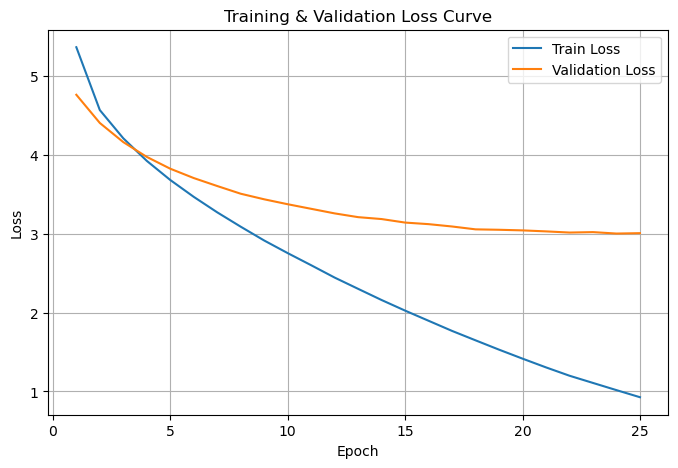

In [25]:
# 학습 곡선 그리기
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss")
if val_loss:
    plt.plot(epochs[:len(val_loss)], val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
print("Q: 오늘도 힘든 하루였어")
print("A:",greedy_decode(model,"오늘도 힘든 하루였어"), "\n")

Q: 오늘도 힘든 하루였어
A: 많이 드시면 안돼요. 



- 너무 심한 과적합이 발생했습니다.
- 어떻게 하면 좋아질까 고민하다가, 작은 Transformer 모델을 만들어봤습니다.

### 6. 기타 실험 (모델 축소 + DropOut 강화 + Label Smoothing 적용)

In [27]:
# 작은 Transformer 모델 정의
small_model = Transformer(
    vocab_size=VOCAB_SIZE, 
    d_model=128,   # 차원 축소
    N=1,           # 레이어 수 축소
    num_heads=4,
    d_ff=256, 
    dropout=0.3    # Dropout 강화
).to(DEVICE)

# Label smoothing이 적용된 손실 함수 (재정의)
# 정답 확률을 살짝 낮춰(1.0 -> 0.9) 모델이 너무 확신하지 안헤 만들어서 과적합을 줄이기
# 작은 데이터셋에서 일반화 성능 향상 가능
criterion = nn.CrossEntropyLoss(ignore_index=PAD, label_smoothing=0.1)

In [28]:
# 학습 실행
train_loss, val_loss = train_model(
    small_model, 
    train_loader, 
    val_loader, 
    n_epochs=25, 
    lr=1e-4
)

Epoch 1: Train Loss 6.1583, Val Loss 5.2221
Epoch 2: Train Loss 5.1269, Val Loss 4.9599
Epoch 3: Train Loss 4.9051, Val Loss 4.8138
Epoch 4: Train Loss 4.7525, Val Loss 4.6893
Epoch 5: Train Loss 4.6179, Val Loss 4.5907
Epoch 6: Train Loss 4.4877, Val Loss 4.4900
Epoch 7: Train Loss 4.3631, Val Loss 4.4025
Epoch 8: Train Loss 4.2475, Val Loss 4.3177
Epoch 9: Train Loss 4.1386, Val Loss 4.2499
Epoch 10: Train Loss 4.0363, Val Loss 4.1826
Epoch 11: Train Loss 3.9392, Val Loss 4.1172
Epoch 12: Train Loss 3.8475, Val Loss 4.0660
Epoch 13: Train Loss 3.7642, Val Loss 4.0140
Epoch 14: Train Loss 3.6861, Val Loss 3.9602
Epoch 15: Train Loss 3.6091, Val Loss 3.9216
Epoch 16: Train Loss 3.5337, Val Loss 3.8809
Epoch 17: Train Loss 3.4630, Val Loss 3.8436
Epoch 18: Train Loss 3.3991, Val Loss 3.8115
Epoch 19: Train Loss 3.3342, Val Loss 3.7767
Epoch 20: Train Loss 3.2715, Val Loss 3.7489
Epoch 21: Train Loss 3.2147, Val Loss 3.7162
Epoch 22: Train Loss 3.1565, Val Loss 3.6946
Epoch 23: Train Los

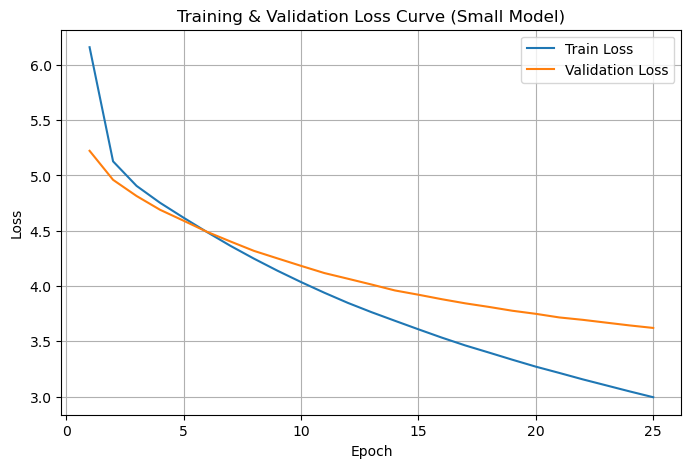

In [29]:
# 학습 곡선 시각화
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss")
if val_loss:
    plt.plot(epochs[:len(val_loss)], val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve (Small Model)")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# 샘플 추론
for q in ["일본 여행을 다녀오기로 했어.", "오늘 비가 많이 오더라.", "집에 갈 생각하니 신난다!"]:
    print("Q:", q)
    print("A:", greedy_decode(small_model, q), "\n")

Q: 일본 여행을 다녀오기로 했어.
A: 게 드세요. 

Q: 오늘 비가 많이 오더라.
A: 게 드세요. 

Q: 집에 갈 생각하니 신난다!
A: 게 드세요. 



### 7. 회고

- 짧고 단순한 문장 + 답변 패턴 제한적 + 중복/유사 문장이 다수 존재하다보니 모델이 말하기 패턴을 학습하기 어려운 데이터셋이라 생각됩니다.
- 그래서 모델이 과적합하거나 단순한 문장만을 출력하게 되어, 자연스러운 대화가 나오지 못했던 것이었습니다.
- 데이터의 답변을 다양화하거나 사전 학습된 언어 모델을 사용하면 해결될 것 같습니다.

In [32]:
df.head(10)

,Q_norm,A_norm
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,ppl 심하네,눈살이 찌푸려지죠.
5,sd카드 망가졌어,다시 새로 사는 게 마음 편해요.
6,sd카드 안돼,다시 새로 사는 게 마음 편해요.
7,sns 맞팔 왜 안하지,잘 모르고 있을 수도 있어요.
8,sns 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.
9,sns 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.
